Load .csv file data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change your path accordingly
path1='/content/drive/MyDrive/Fetus_Classification/Fetus_trainingdata.csv'
path2='/content/drive/MyDrive/Fetus_Classification/Fetus_testingdata.csv'

In [ ]:
with open(path1,'r') as n:
  print('Fetus_trainingdata.csv\n',n.read())
with open(path2,'r') as t:
  print('Fetus_testingdata.csv\n', t.read())

Fetus_trainingdata.csv
 Outcome,Age,Ethnics,Biparietal Diameter,Head Circumference,Cerebellum_tr,Cisterna Magna,Estimated Fetal Weight ,Nuchal_fold,Abdominal circumference,Femur Length,Va,Vp,Hem,RI (Right),PI (Right),GA_scan_day
Preterm,32,2,52,191.9,24,7.3,452,4.2,169.8,37,5.5,7.2,24.8,0.53,0.85,21.85714286
Preterm,33,2,54.5,191.4,22.4,6.8,389,3.9,160.5,33.7,6.5,7.2,27.1,0.46,0.63,21.71428571
Preterm,46,1,54.9,194.8,21.8,6.8,432,3.04,167.1,35.7,7.9,6.6,26.8,1.63,1.63,22.57142857
Preterm,38,3,52.1,196.4,23.4,7.3,420,3.91,157.9,37.1,7.7,5.7,24.8,0.57,0.92,22.28571429
Preterm,31,1,52.4,186,21.7,5,410,4.55,157.7,37.2,6.4,4.7,25.2,0.34,0.43,22.14285714
Healthy,35,3,49.1,183.2,22.4,5.8,396,4.32,164.3,34.1,5.7,5.1,22,0.58,0.92,21.85714286
Preterm,21,1,50.8,186.6,21.2,6.3,417,3.95,169.2,34.2,6.13,5.91,23.46,0.82,2.1,21.85714286
Preterm,40,1,49.4,183.8,20.7,4.7,370,4.55,154.4,34.3,5.5,6.1,21.3,0.58,1.01,21.71428571
Healthy,29,1,51.1,188.7,21.8,6.6,470,4.56,171.6,38.5,6.9,6,24.7,0.44,0.6,21.857

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
training_data = pd.read_csv(path1)
testing_data = pd.read_csv(path2)

# Preprocess the data
def preprocess_data(df):
    le = LabelEncoder()
    df['Outcome'] = le.fit_transform(df['Outcome'])
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y.values, dtype=torch.long)

X_train, y_train = preprocess_data(training_data)
X_test, y_test = preprocess_data(testing_data)

# Create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoaders
batch_size = 64  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers=1):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.hidden_layers.extend([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output(x)
        return x

# Initialize the model
model = MLP(input_size=X_train.shape[1], hidden_size=100, output_size=2, hidden_layers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, total_correct, total = 0, 0, 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_correct += (predicted == target).sum().item()
            total += target.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total

        # Evaluation
        model.eval()
        test_loss, test_correct, total = 0, 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_correct += (predicted == target).sum().item()
                total += target.size(0)
        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / total

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.6894, Train Acc: 54.05%, Test Loss: 0.6470, Test Acc: 70.69%
Epoch 2/10, Train Loss: 0.6613, Train Acc: 63.58%, Test Loss: 0.6299, Test Acc: 81.03%
Epoch 3/10, Train Loss: 0.6460, Train Acc: 64.16%, Test Loss: 0.6081, Test Acc: 79.31%
Epoch 4/10, Train Loss: 0.6295, Train Acc: 67.34%, Test Loss: 0.5951, Test Acc: 74.14%
Epoch 5/10, Train Loss: 0.6160, Train Acc: 69.08%, Test Loss: 0.5758, Test Acc: 74.14%
Epoch 6/10, Train Loss: 0.6014, Train Acc: 69.65%, Test Loss: 0.5544, Test Acc: 74.14%
Epoch 7/10, Train Loss: 0.5832, Train Acc: 70.81%, Test Loss: 0.5463, Test Acc: 72.41%
Epoch 8/10, Train Loss: 0.5732, Train Acc: 71.97%, Test Loss: 0.5388, Test Acc: 70.69%
Epoch 9/10, Train Loss: 0.5485, Train Acc: 72.54%, Test Loss: 0.5239, Test Acc: 72.41%
Epoch 10/10, Train Loss: 0.5572, Train Acc: 72.25%, Test Loss: 0.5199, Test Acc: 70.69%


Using Random Search:

In [ ]:
import random

# Function to perform random search
def random_search(num_experiments=5):
    for _ in range(num_experiments):
        batch_size = random.choice([32, 64, 128])
        hidden_size = random.choice([50, 100, 200])
        hidden_layers = random.choice([1, 2, 3])
        learning_rate = 10**random.uniform(-4, -2)  # Random log scale for learning rate
        print(f"Random Search - Batch Size: {batch_size}, Hidden Size: {hidden_size}, Hidden Layers: {hidden_layers}, Learning Rate: {learning_rate}")

        # Initialize the model and optimizer with the current hyperparameters
        model = MLP(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=2, hidden_layers=hidden_layers)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Run training and evaluation
        train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10)

random_search(num_experiments=5)

Random Search - Batch Size: 64, Hidden Size: 200, Hidden Layers: 1, Learning Rate: 0.0009008116716590533
Epoch 1/10, Train Loss: 0.6843, Train Acc: 56.07%, Test Loss: 0.6372, Test Acc: 63.79%
Epoch 2/10, Train Loss: 0.6464, Train Acc: 61.56%, Test Loss: 0.6148, Test Acc: 68.97%
Epoch 3/10, Train Loss: 0.6410, Train Acc: 65.61%, Test Loss: 0.5930, Test Acc: 74.14%
Epoch 4/10, Train Loss: 0.6272, Train Acc: 67.05%, Test Loss: 0.5736, Test Acc: 75.86%
Epoch 5/10, Train Loss: 0.6236, Train Acc: 67.92%, Test Loss: 0.5610, Test Acc: 72.41%
Epoch 6/10, Train Loss: 0.6020, Train Acc: 67.92%, Test Loss: 0.5542, Test Acc: 72.41%
Epoch 7/10, Train Loss: 0.5950, Train Acc: 68.21%, Test Loss: 0.5492, Test Acc: 72.41%
Epoch 8/10, Train Loss: 0.5870, Train Acc: 68.21%, Test Loss: 0.5525, Test Acc: 72.41%
Epoch 9/10, Train Loss: 0.5810, Train Acc: 70.81%, Test Loss: 0.5507, Test Acc: 74.14%
Epoch 10/10, Train Loss: 0.5783, Train Acc: 71.68%, Test Loss: 0.5385, Test Acc: 74.14%
Random Search - Batch Si

Plotting Graph:

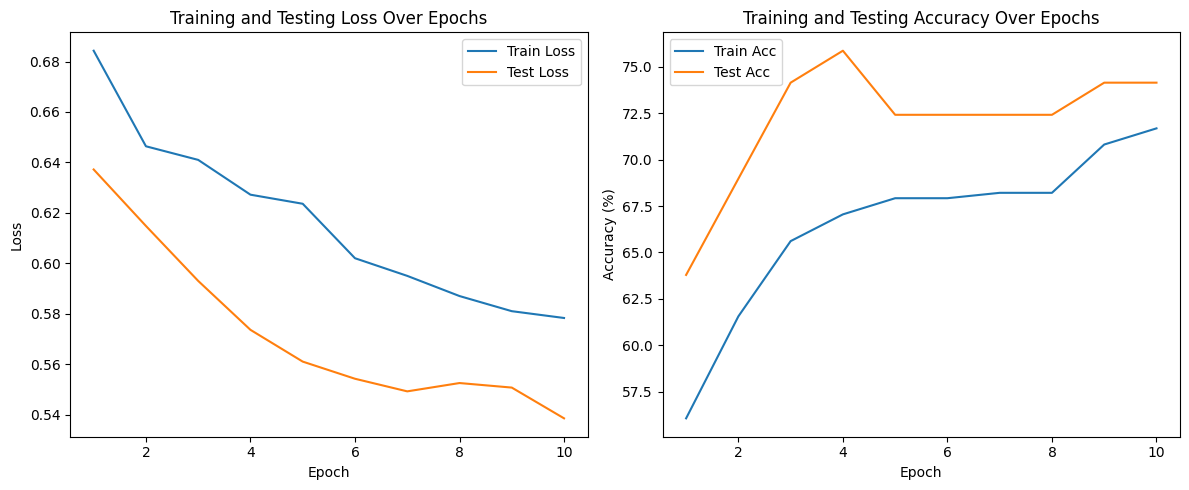

In [ ]:
import matplotlib.pyplot as plt

# Data from the best model
best_model_data = {
    'Epoch': list(range(1, 11)),
    'Train Loss': [0.6843, 0.6464, 0.6410, 0.6272, 0.6236, 0.6020, 0.5950, 0.5870, 0.5810, 0.5783],
    'Test Loss': [0.6372, 0.6148, 0.5930, 0.5736, 0.5610, 0.5542, 0.5492, 0.5525, 0.5507, 0.5385],
    'Train Acc': [56.07, 61.56, 65.61, 67.05, 67.92, 67.92, 68.21, 68.21, 70.81, 71.68],
    'Test Acc': [63.79, 68.97, 74.14, 75.86, 72.41, 72.41, 72.41, 72.41, 74.14, 74.14],
}

# Plot training and testing loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_model_data['Epoch'], best_model_data['Train Loss'], label='Train Loss')
plt.plot(best_model_data['Epoch'], best_model_data['Test Loss'], label='Test Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(best_model_data['Epoch'], best_model_data['Train Acc'], label='Train Acc')
plt.plot(best_model_data['Epoch'], best_model_data['Test Acc'], label='Test Acc')
plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
